```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook takes drifter positions from OpenDrift into an
Observation file.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting


In [3]:
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:
# How many cells to erode of land
erode_land=1

sponge_cell_num = 40
sponge_cells = {'north': sponge_cell_num, 'south': sponge_cell_num, 'east': sponge_cell_num, 'west': sponge_cell_num}

case_name = 'lovese'

out_folder = os.path.join(datetime.date.today().isoformat(), case_name)

os.makedirs(out_folder, exist_ok=True)
print("Output will be placed in '" + out_folder + "'")

Output will be placed in '2019-12-03/lovese'


# Inspect URL and select area

In [5]:
norkyst800_url = [
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071900.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072000.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072100.nc'
]
source_url = norkyst800_url

required_num_files = np.int(np.floor(3 / 24)) + 1
print(norkyst800_url[:required_num_files])

['https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc']


### Load relevant variables

In [6]:

case_location = NetCDFInitialization.getCaseLocation(case_name)
x0 = case_location['x0']
x1 = case_location['x1']
y0 = case_location['y0']
y1 = case_location['y1']

try:
    ncfile = Dataset(source_url[0])
    X = ncfile.variables['X'][:]#[x0:x1]
    Y = ncfile.variables['Y'][:]#[y0:y1]
except Exception as e:
    raise e
finally:
    ncfile.close()

We need to transform the positions into the domain defined by our chosen case.

Note also that we need to remove extra two cells, as the internal representation of drifter positions are on the domain ***without*** ghost cells.

In [7]:
print(type(X))
print(X[0], X[-1])
print(len(X), X[-1]/800)


x_zero_ref = X[x0+2]
y_zero_ref = Y[y0+2]

domain_size_x = (x1-x0-4)*800
domain_size_y = (y1-y0-4)*800

<class 'numpy.ma.core.MaskedArray'>
0.0 2080800.0
2602 2601.0


### Load the opendrift data:

In [8]:
t, x, y = np.load('t_x_y_from_opendrift.npy', allow_pickle=True)
print(t.shape)
print('x', type(x), x.shape )
print('y', type(y), y.shape )

#print(x.mask)
#print(x.shape)

#print(x[:,-1])

(1717,)
x <class 'numpy.ma.core.MaskedArray'> (400, 1717)
y <class 'numpy.ma.core.MaskedArray'> (400, 1717)


In [9]:
# Drop drifters that hit land
x = np.ma.compress_rows(np.ma.masked_invalid(x))
y = np.ma.compress_rows(np.ma.masked_invalid(y))
print(x.shape, y.shape)


(252, 1717) (252, 1717)


Fit into our domain

In [10]:
x = x - x_zero_ref
y = y - y_zero_ref

Create a mask to find the drifters that is not entirely within our domain

In [11]:
# Start by those that are outside the domain in the negative direction

x = np.ma.masked_array(x, x < 0)
y = np.ma.masked_array(y, y < 0)

print(x.mask.sum(), y.mask.sum(), x.shape[0]*x.shape[1])



#neg_mask = np.logical_not(y.mask) & np.logical_not(x.mask)
#neg_mask = np.logical_not(np.logical_and(np.logical_not(y.mask), np.logical_not(x.mask)))
neg_mask = np.logical_or(y.mask, x.mask)
print(neg_mask.sum())


x.mask = neg_mask
y.mask = neg_mask

x = np.ma.compress_rows(np.ma.masked_invalid(x))
y = np.ma.compress_rows(np.ma.masked_invalid(y))

print(x.min(), x.max(), domain_size_x)
print(y.min(), y.max(), domain_size_y)
#print(x.mask.sum(), y.mask.sum(), x.shape[0]*x.shape[1])

print(x.shape, y.shape)


34161 0 432684
34161
4899.378988521406 634122.8939919828 504000
13807.2012285206 461719.551418677 252000
(229, 1717) (229, 1717)


In [12]:
# Then fix those that are outside in positive direction

x = np.ma.masked_array(x, x > domain_size_x)
y = np.ma.masked_array(y, y > domain_size_y)

print(x.mask.sum(), y.mask.sum(), x.shape[0]*x.shape[1])



#neg_mask = np.logical_not(y.mask) & np.logical_not(x.mask)
#neg_mask = np.logical_not(np.logical_and(np.logical_not(y.mask), np.logical_not(x.mask)))
neg_mask = np.logical_or(y.mask, x.mask)
print(neg_mask.sum())


x.mask = neg_mask
y.mask = neg_mask

x = np.ma.compress_rows(np.ma.masked_invalid(x))
y = np.ma.compress_rows(np.ma.masked_invalid(y))

print(x.min(), x.max(), domain_size_x)
print(y.min(), y.max(), domain_size_y)
#print(x.mask.sum(), y.mask.sum(), x.shape[0]*x.shape[1])

print(x.shape, y.shape)


47277 145265 393193
191962
4899.378988521406 503806.2295244683 504000
13807.2012285206 251838.53178002848 252000
(111, 1717) (111, 1717)


The remaining drifters should now all be completely within the wet part of the domain. 

### Create a sim, just for convenience of providing parameters to the Observation

In [13]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0,
    "write_netcdf": True,
    "model_time_step": 60
}

data_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url[0], case_name,
                                                                  timestep_indices=None,
                                                                  erode_land=erode_land,
                                                                  sponge_cells=sponge_cells,
                                                                  download_data=False)

sim = CDKLM16.CDKLM16(**sim_args, 
                      **NetCDFInitialization.removeMetadata(data_args))

# Some hard coded positions that are not on land
drifter_positions=np.array([[ 50, 110],
                            [110, 110],
                            [170, 110],
                            [290, 115],
                            [410, 115],
                            [470, 120],
                            [ 50, 155],
                            [200, 165]
                            ], dtype=np.float32)
num_drifters = drifter_positions.shape[0]
print('num_drifters: ' + str(num_drifters))

drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                     domain_size_x=sim.nx*sim.dx,
                                                     domain_size_y=sim.ny*sim.dy)
drifters.setDrifterPositions(drifter_positions*1000)

sim.attachDrifters(drifters)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


num_drifters: 8


In [14]:
sim.drifters.getDrifterPositions().shape

(8, 2)

### Create observation file and feed in the open drift results

In [15]:
#--------------------------------------------------------------
# Create observation object and write the first drifter positions
#--------------------------------------------------------------
observations = Observation.Observation(domain_size_x = sim.nx*sim.dx,
                                       domain_size_y = sim.ny*sim.dy,
                                       nx=sim.nx, ny=sim.ny,
                                       land_mask=sim.getLandMask())

In [16]:
print(observations.obs_df)

Empty DataFrame
Columns: [time, drifter_positions, drifter_obs_errors, buoy_observations, buoy_positions, buoy_obs_errors]
Index: []


In [17]:

observations.add_observations_from_arrays(t, x, y)

In [18]:
observations.get_num_drifters(), observations.get_num_observations()

(111, 1717)

In [19]:
observations.get_observation_times()

array([3.000e+02, 6.000e+02, 9.000e+02, ..., 5.142e+05, 5.145e+05,
       5.148e+05])

In [20]:

#store observation file
observation_filename = 'opendrift_observations_'+datetime.datetime.now().strftime("%H_%M_%S")+'.pickle'
observations.to_pickle(os.path.join(out_folder, observation_filename))



# Read observation file and plot some results

In [21]:
importlib.reload(Observation)

obs = Observation.Observation(observation_type=dautils.ObservationType.UnderlyingFlow,
                              domain_size_x=sim.nx*sim.dx, domain_size_y=sim.ny*sim.dx,
                              nx=sim.nx, ny=sim.ny,
                              land_mask=sim.getLandMask())
obs.read_pickle(os.path.join(out_folder, observation_filename))

In [22]:
end_t = obs.get_observation_times()[-1]

num_drifters = obs.get_num_drifters(ignoreBuoys=True)
print('num drifters (ignoring buoys)', num_drifters)
drifter_paths = [None]*num_drifters
for i in range(num_drifters):
    drifter_paths[i] = obs.get_drifter_path(i, 0, end_t)

num drifters (ignoring buoys) 111


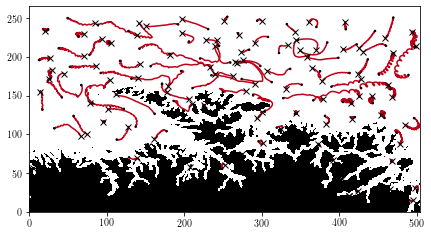

In [23]:
def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.3)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.7)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)
        
def createForecastCanvas(observation):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/1000
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax

ax = createForecastCanvas(obs)
for drifter_path in drifter_paths:
    forecastPlot(ax, drifter_path, [], truth_point_size=1)
    


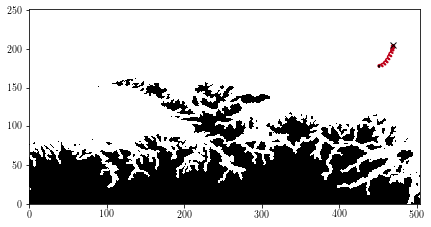

In [24]:
ax = createForecastCanvas(obs)

forecastPlot(ax, drifter_paths[103], [], truth_point_size=1)
    
